In [1]:
import numpy as np
from scipy import linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.collections
import matplotlib.patches
import pg_fitter_tools as fit
import cv2
from collections import Counter

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%matplotlib notebook

In [4]:
focal_length = np.array([1742, 1744])
principle_point = np.array([2000, 1500])
radial_distortion = np.array([-0.251, 0.0689])
tangential_distortion = np.array([0, 0])
camera_matrix = fit.build_camera_matrix(focal_length, principle_point)
distortion = fit.build_distortion_array(radial_distortion, tangential_distortion)

In [5]:
cv2.Rodrigues(np.array([[0.,0,-1],[1,0,0],[0,-1,0]]))[0]

array([[-1.20919958],
       [-1.20919958],
       [ 1.20919958]])

In [6]:
camera_rotations = np.array([
    [0, 0, 0],         # facing +z
    [0, +np.pi, 0],    # facing -z
    [0, -np.pi/2, 0],  # facing +x
    [0, +np.pi/2, 0],  # facing -x
    [+np.pi/2, 0, 0],  # facing +y
    [-2*np.pi/np.sqrt(27), -2*np.pi/np.sqrt(27), 2*np.pi/np.sqrt(27)]]) # facing -y, and rotated 90 degrees about camera axis
camera_radial_position = 400
camera_halfz_position = 300
camera_translations = np.array([ # rotation already applied so just shift in z-dir to place camera at wall
    [0., 0., camera_radial_position],
    [0., 0., camera_radial_position],
    [0., 0., camera_radial_position],
    [0., 0., camera_radial_position],
    [0., 0., camera_halfz_position],
    [0., 0., camera_halfz_position]])

In [21]:
pmt_locations = fit.read_3d_feature_locations("parameters/IWCD_PMT_locations.txt", delimiter=" ")
#mpmt_locations = {k: v for k, v in pmt_locations.items() if int(k)%19==0}
mpmt_locations = fit.read_3d_feature_locations("parameters/IWCD_centrePMT_locations.txt", delimiter=" ")
mpmt_orientations = {k: np.array((0,-1,0)) if v[1]>290 else np.array((0,1,0)) if v[1]<-290 else np.array((-v[0],0,-v[2]))/np.sqrt(v[0]**2+v[2]**2) for k, v in mpmt_locations.items()}
led_ring_radius = 24.
led_count = 12
led_positions_12 = {}
for k, v in mpmt_locations.items():
    for i in range(led_count):
        if abs(v[1]) > 290:
            led_positions_12[k+'_'+str(i)] = v+led_ring_radius*np.array([np.sin(i*2*np.pi/led_count),0,np.cos(i*2*np.pi/led_count)])
        else:
            phi = np.arctan2(v[2], v[0])
            led_positions_12[k+'_'+str(i)] = v+led_ring_radius*np.array([np.sin(i*2*np.pi/led_count)*np.sin(phi), np.cos(i*2*np.pi/led_count), -np.sin(i*2*np.pi/led_count)*np.cos(phi)])

In [22]:
nimages = len(camera_translations)
nfeatures = len(led_positions_12)

In [23]:
image_feature_locations = {
    i : {list(led_positions_12.keys())[f]:v for f, v in enumerate(
        cv2.projectPoints(np.array(list(led_positions_12.values())), r, t,
                          camera_matrix, distortion)[0].reshape((-1,2)))
         if v[0] > 0 and v[0] < 4000 and v[1] > 0 and v[1] < 3000}
    for i, (r, t) in enumerate(zip(camera_rotations, camera_translations))}

<IPython.core.display.Javascript object>


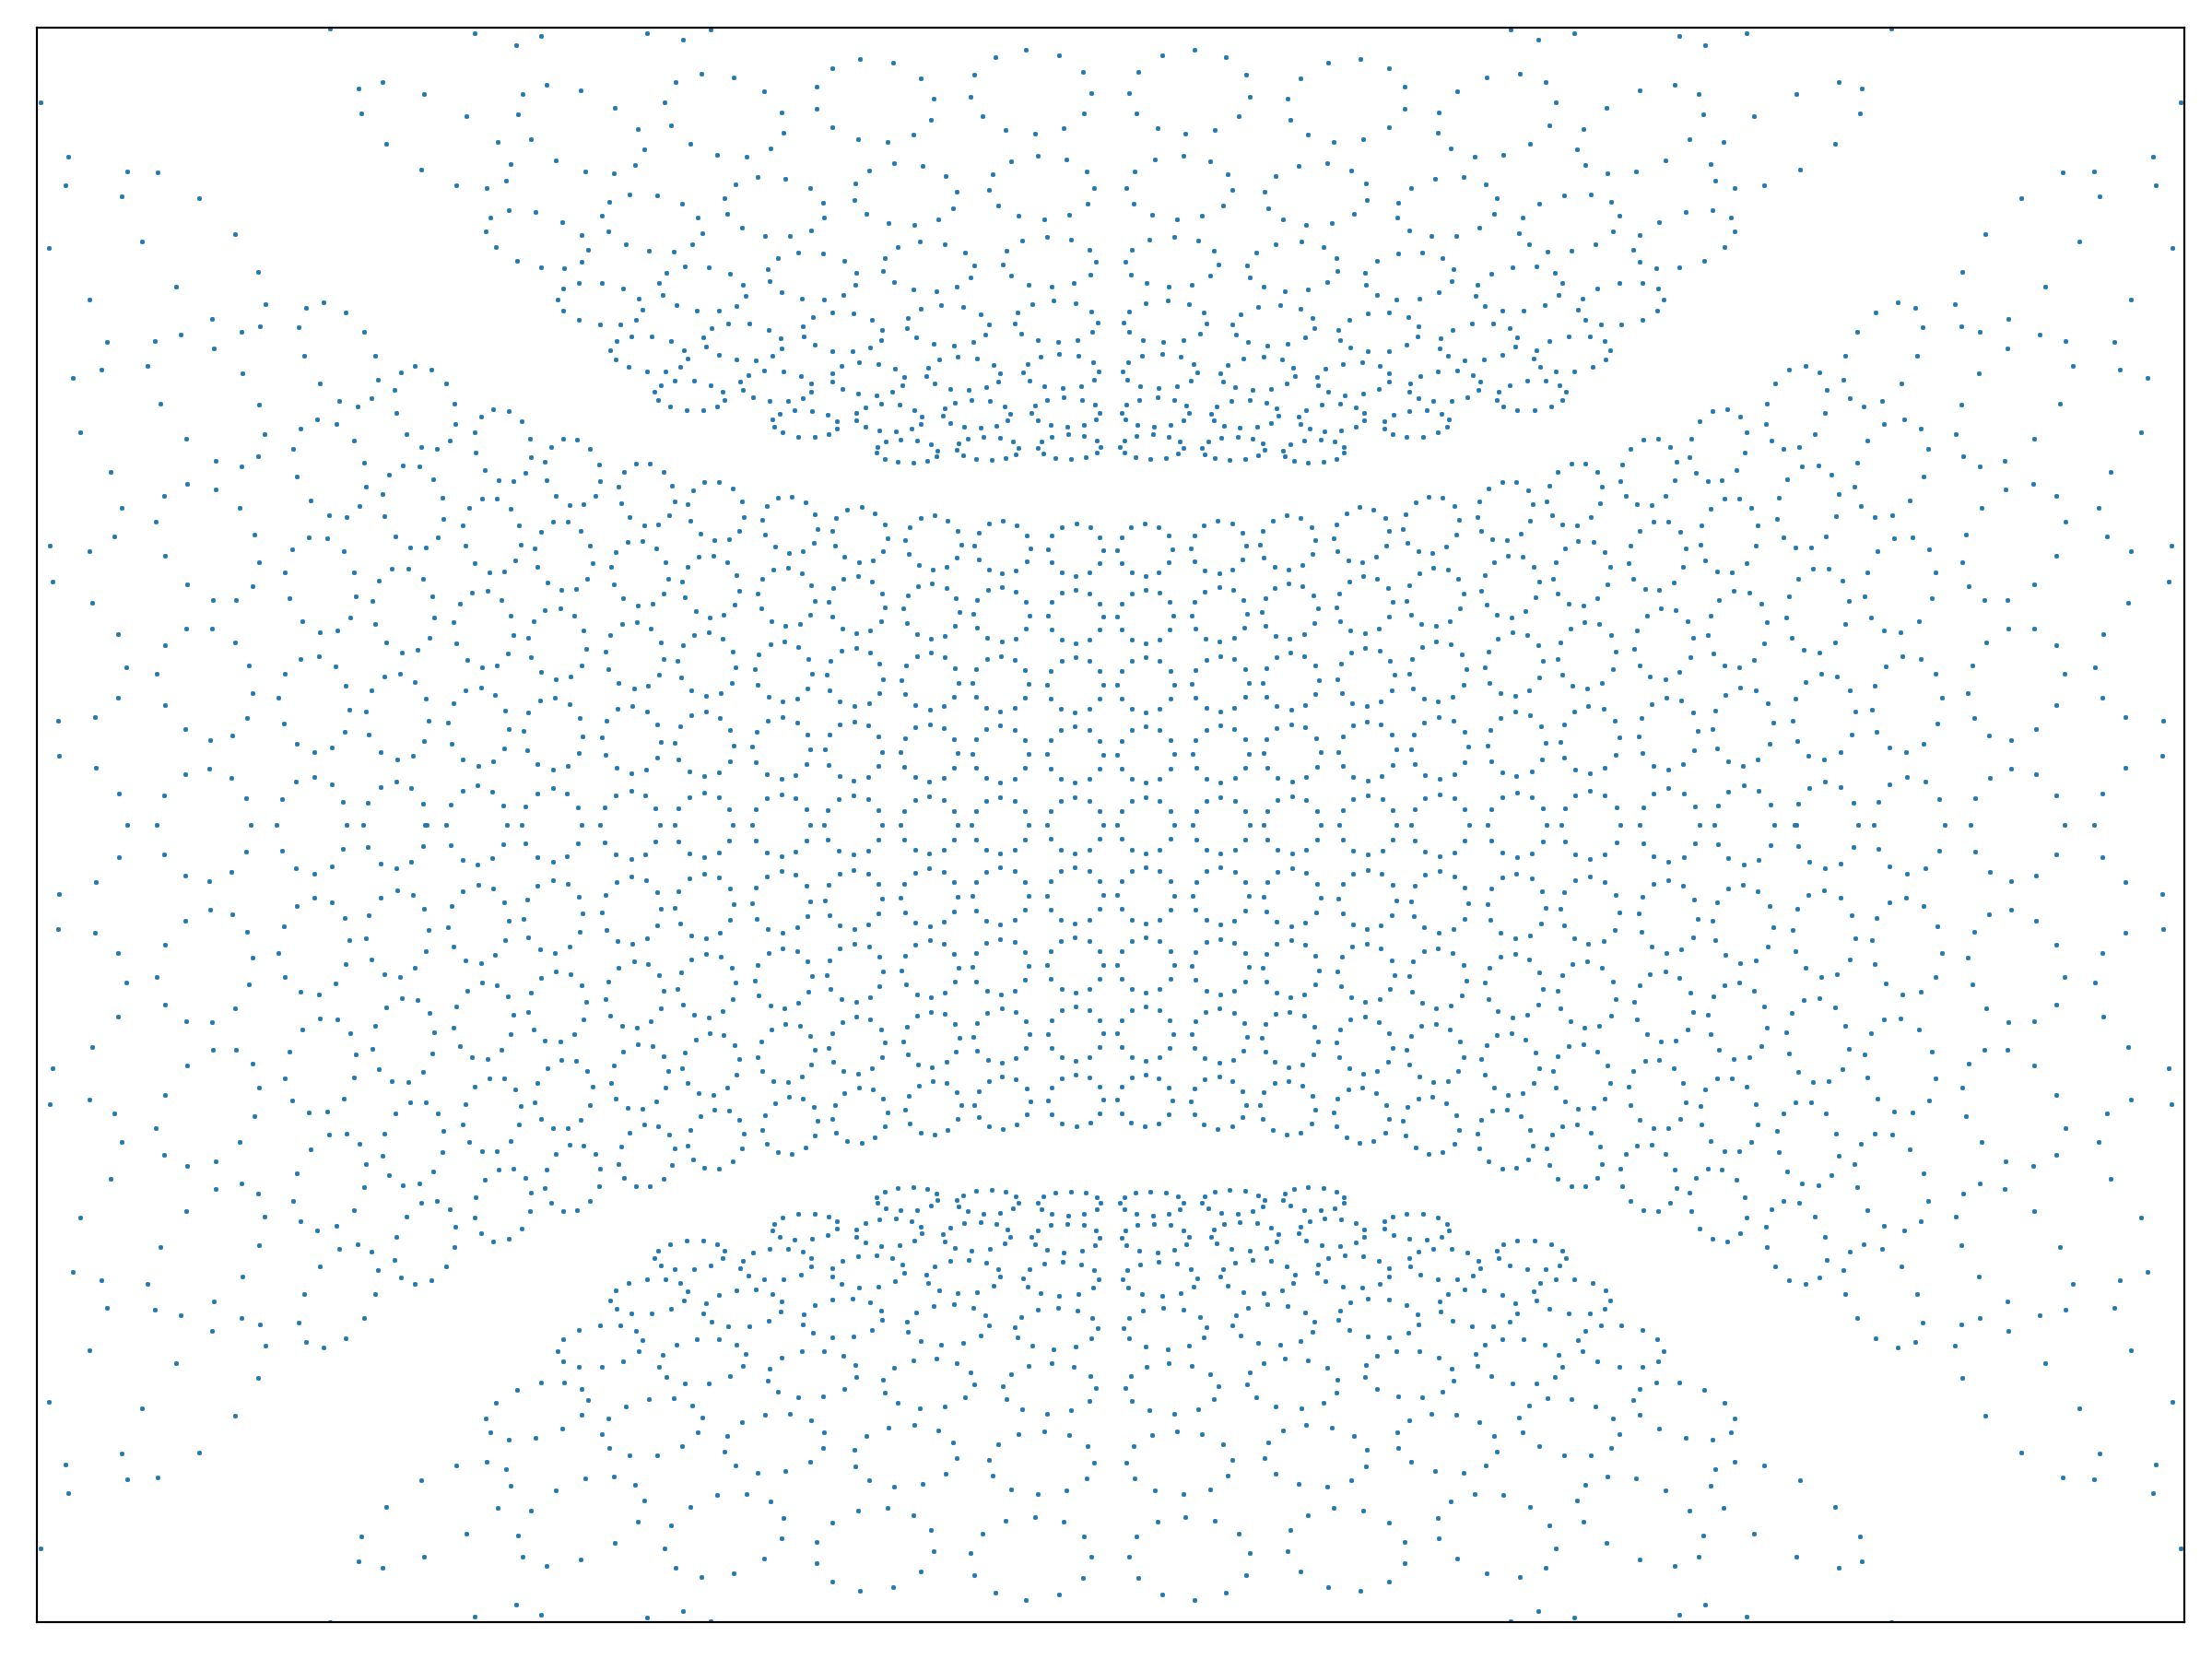

<IPython.core.display.Javascript object>


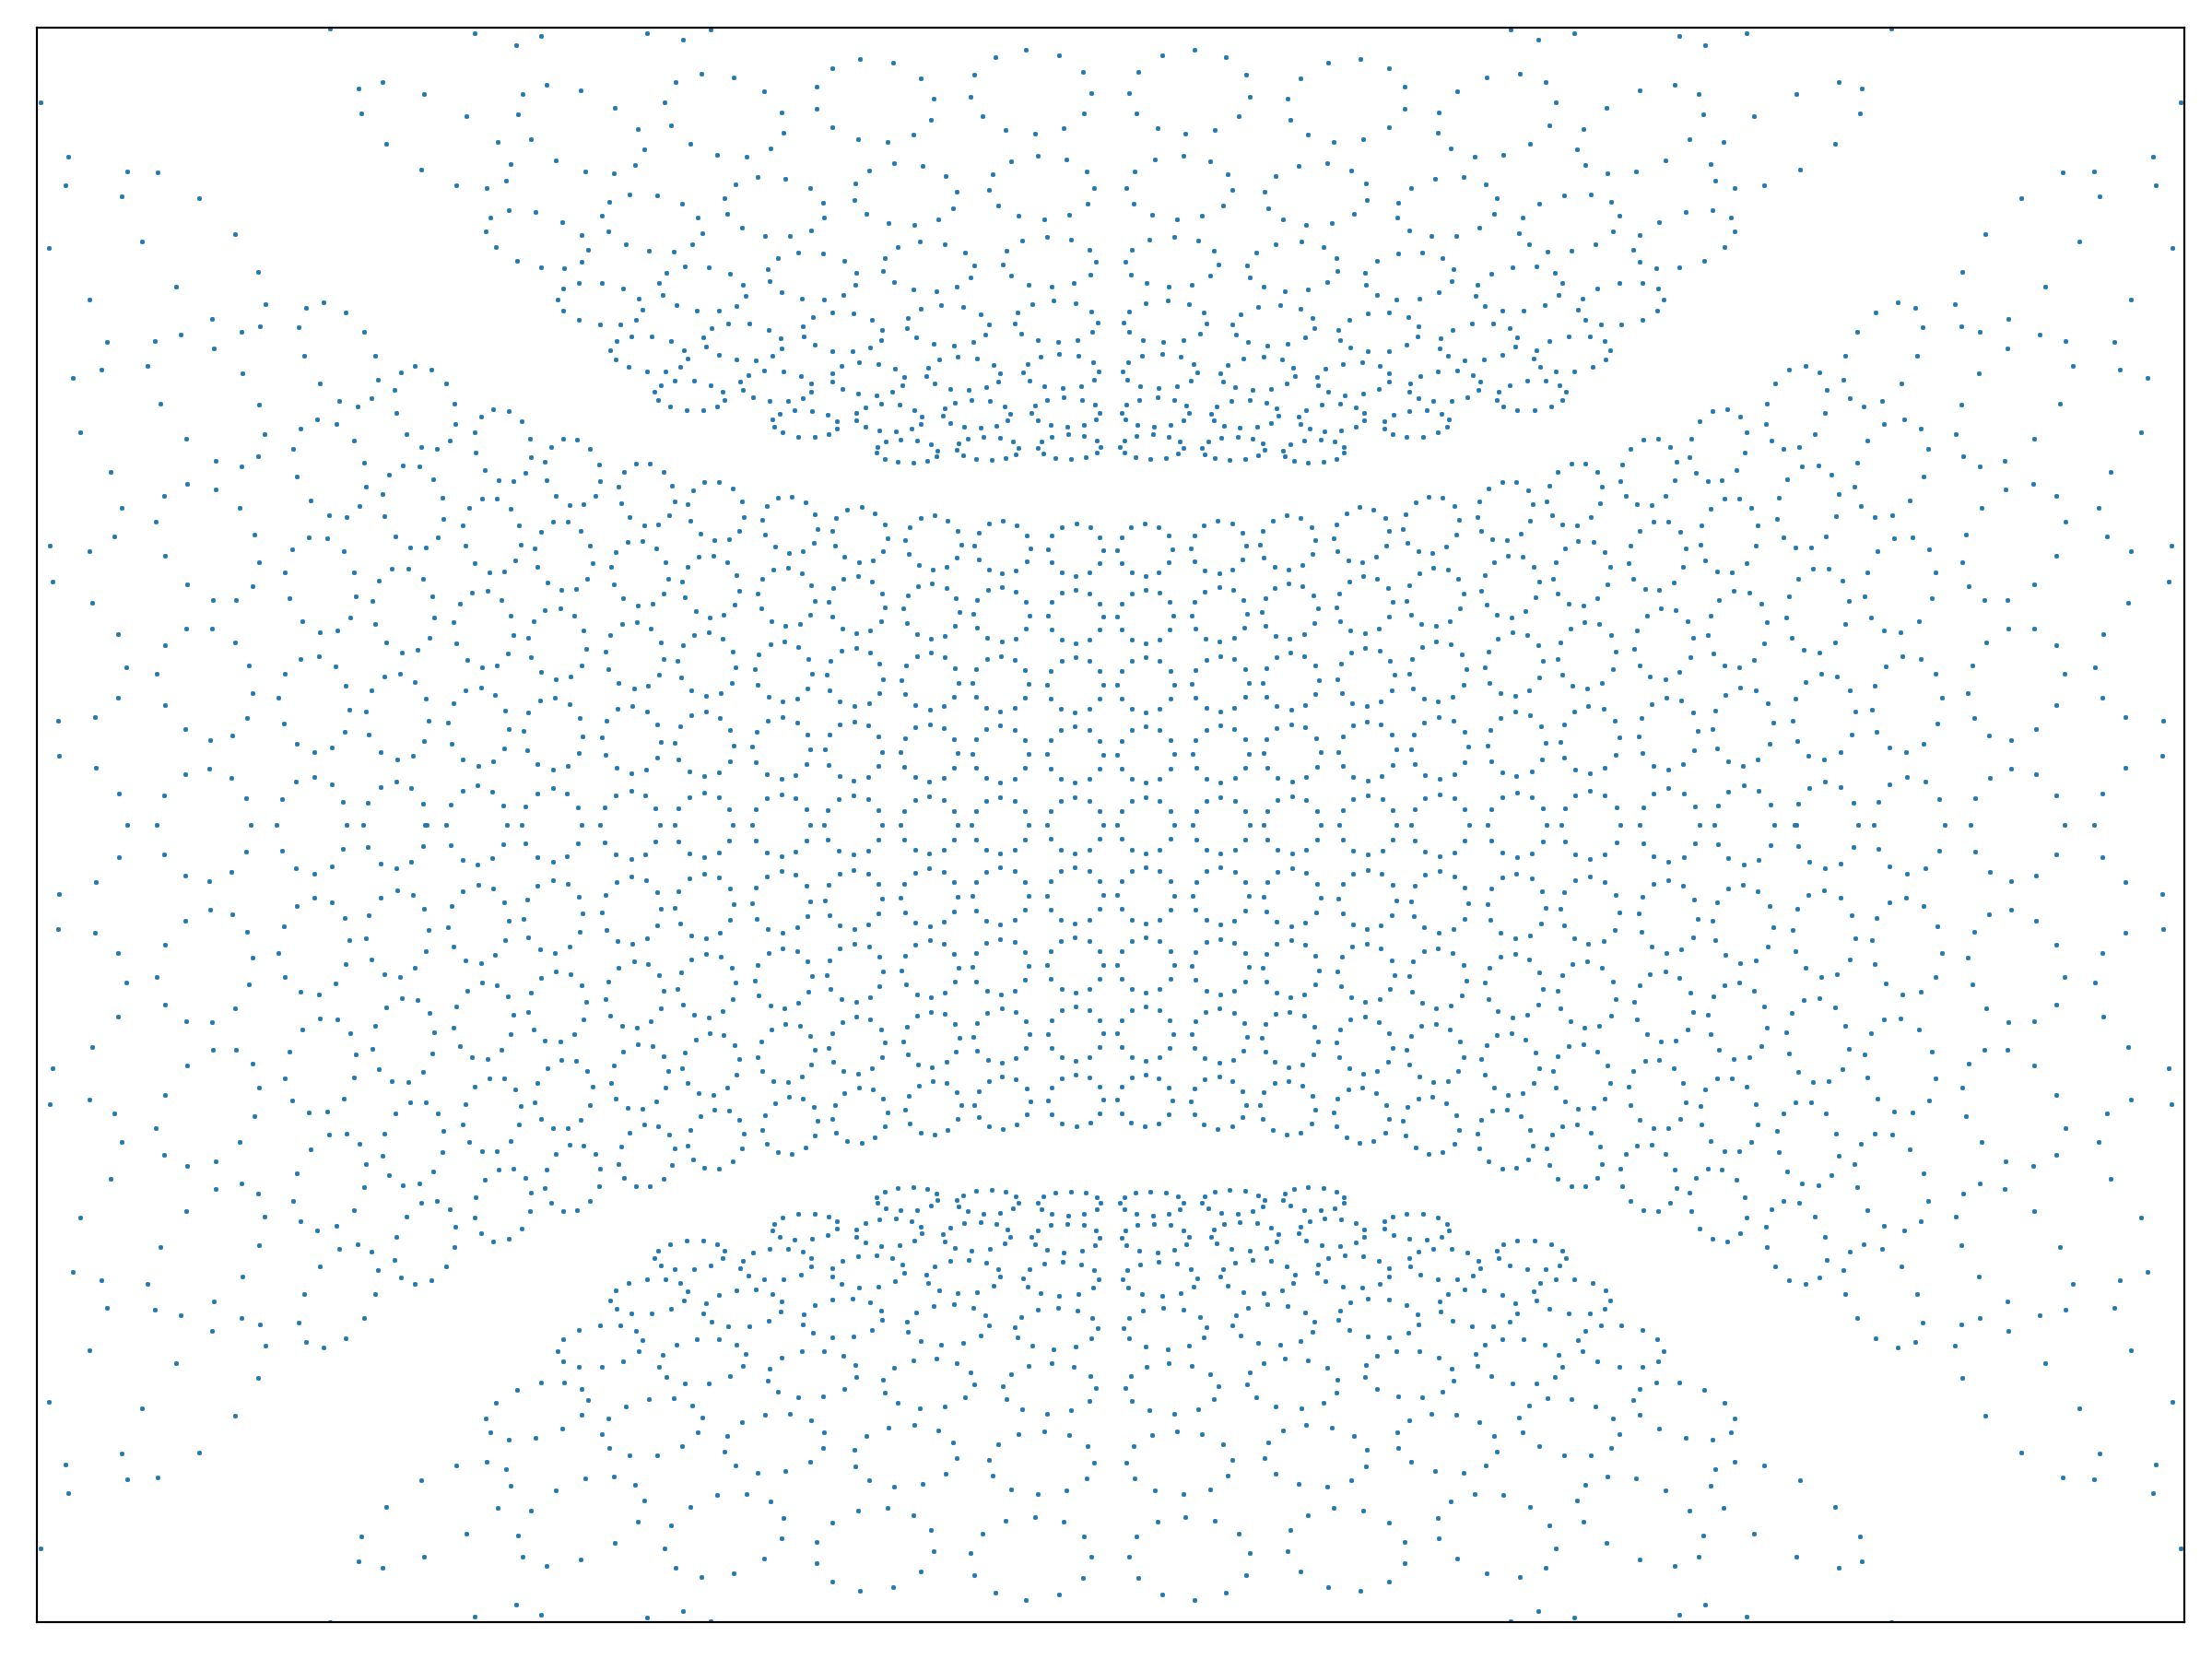

<IPython.core.display.Javascript object>


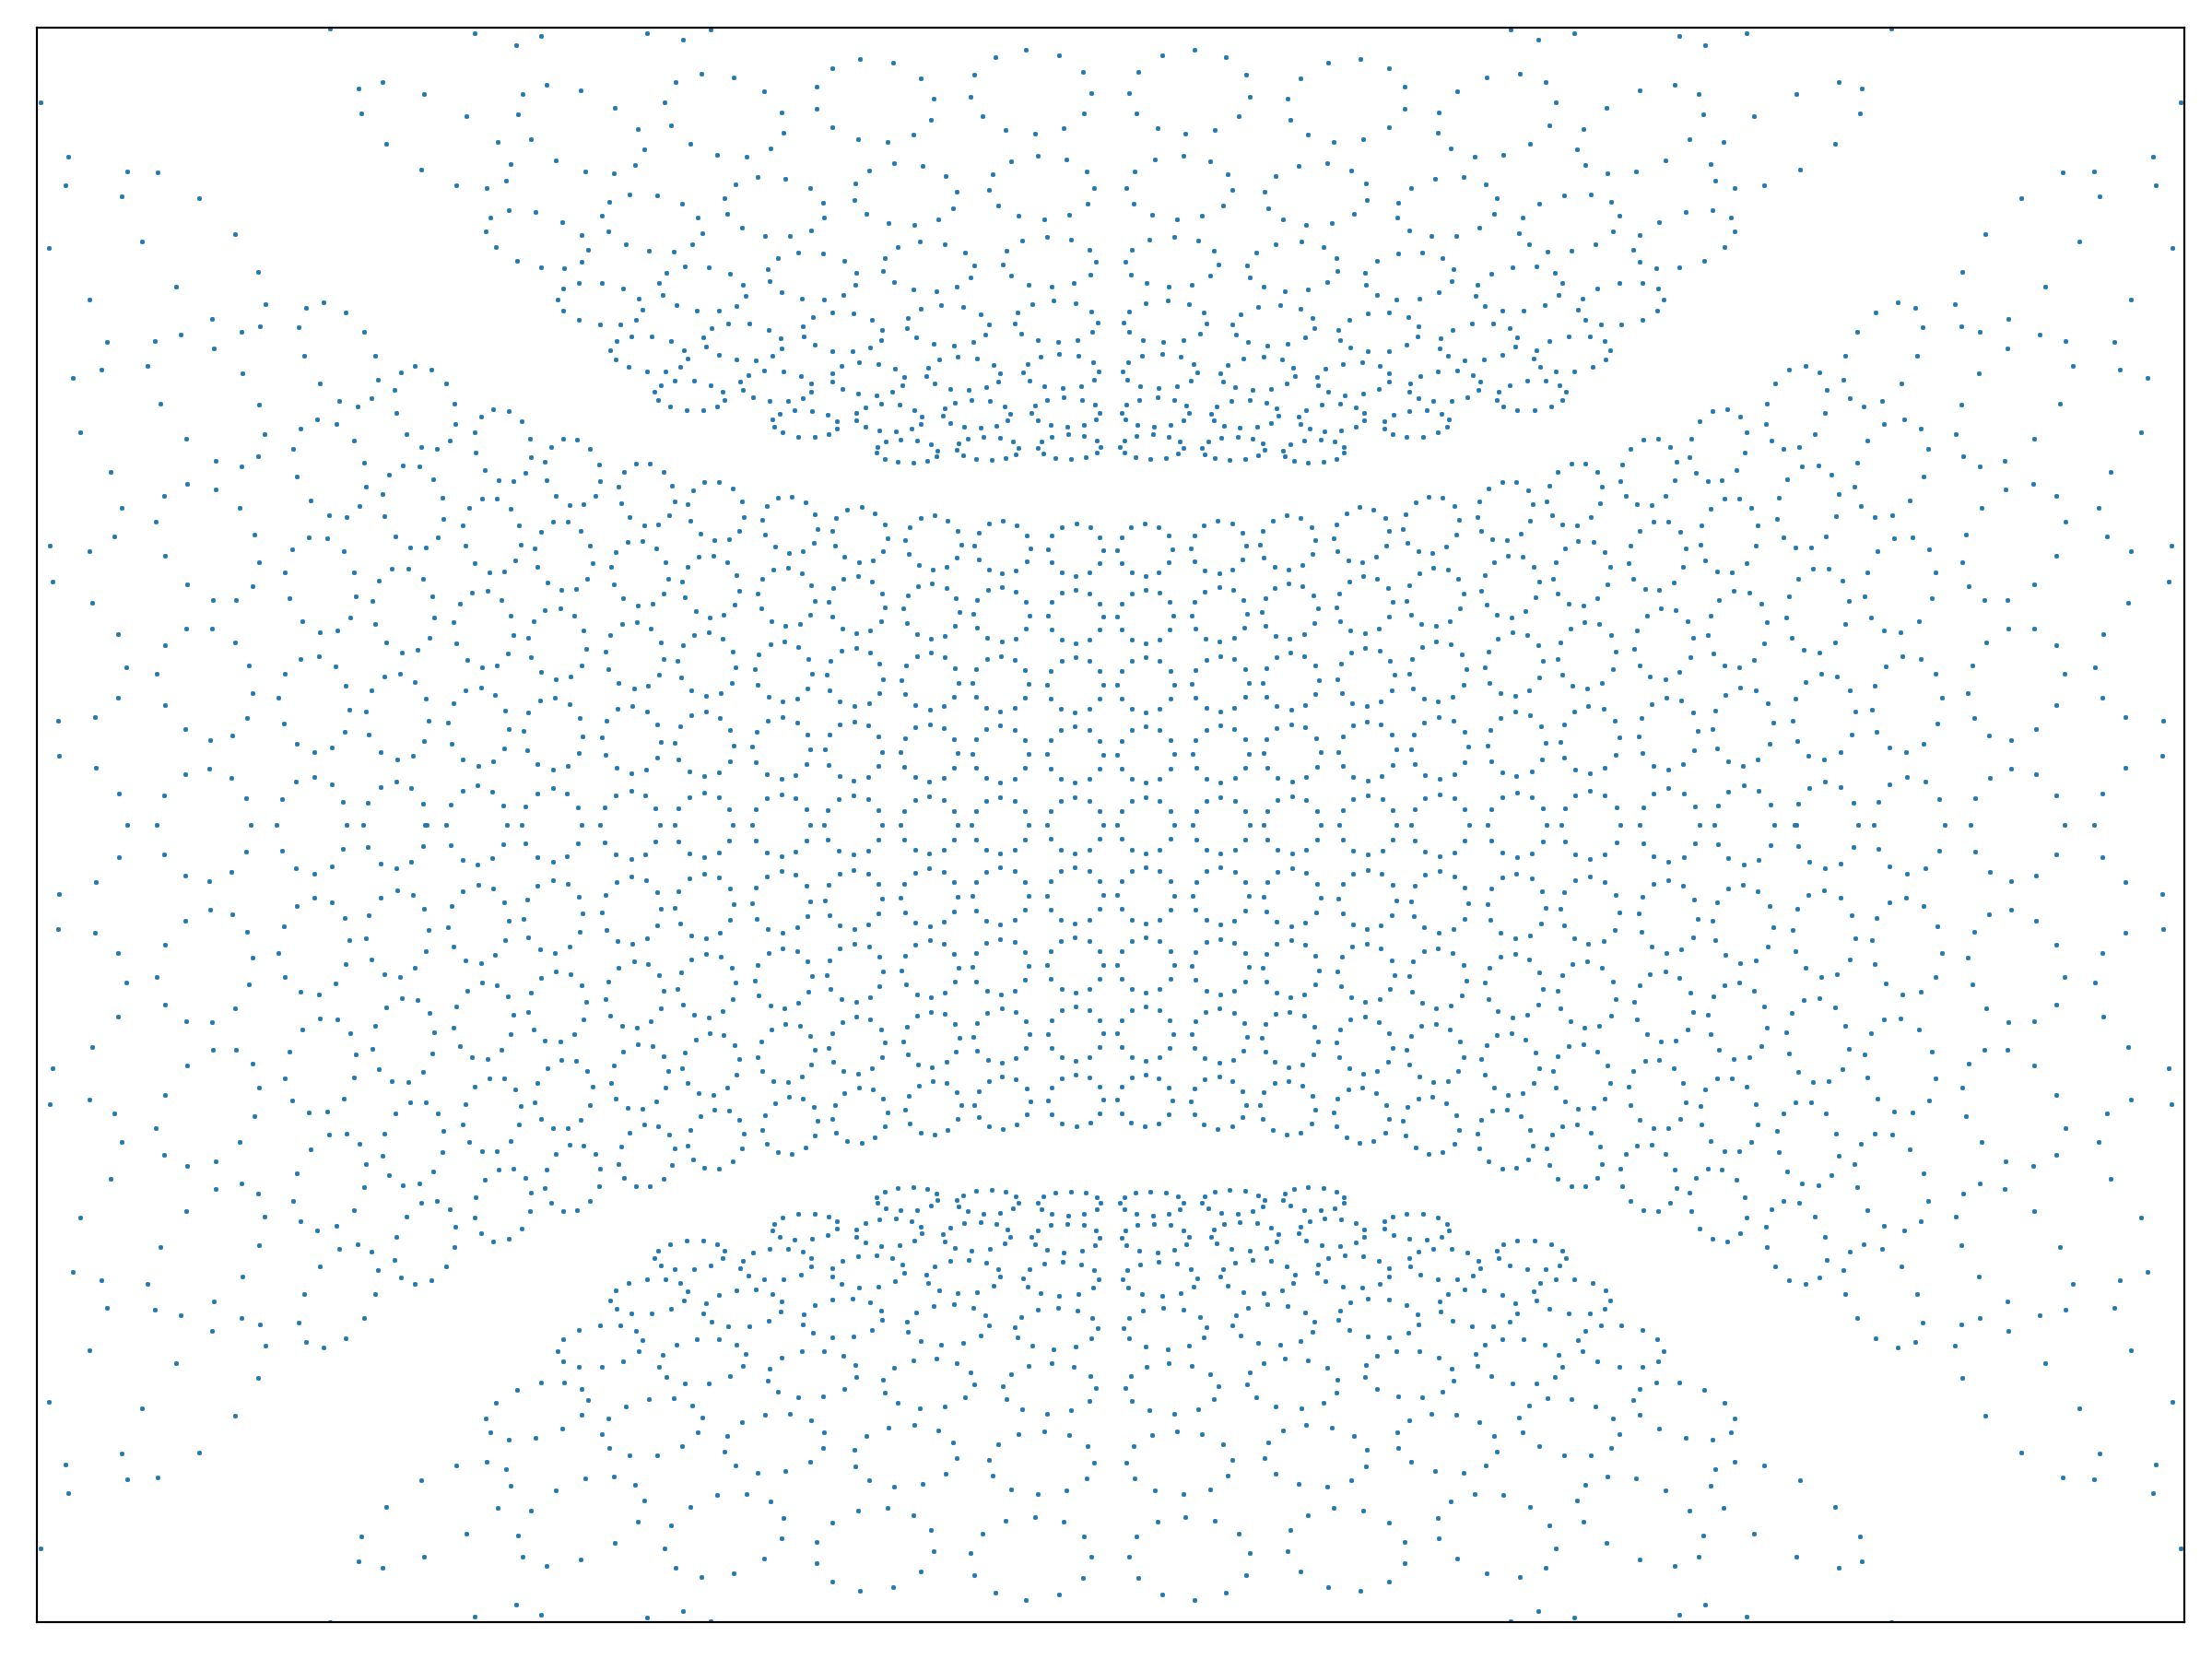

<IPython.core.display.Javascript object>


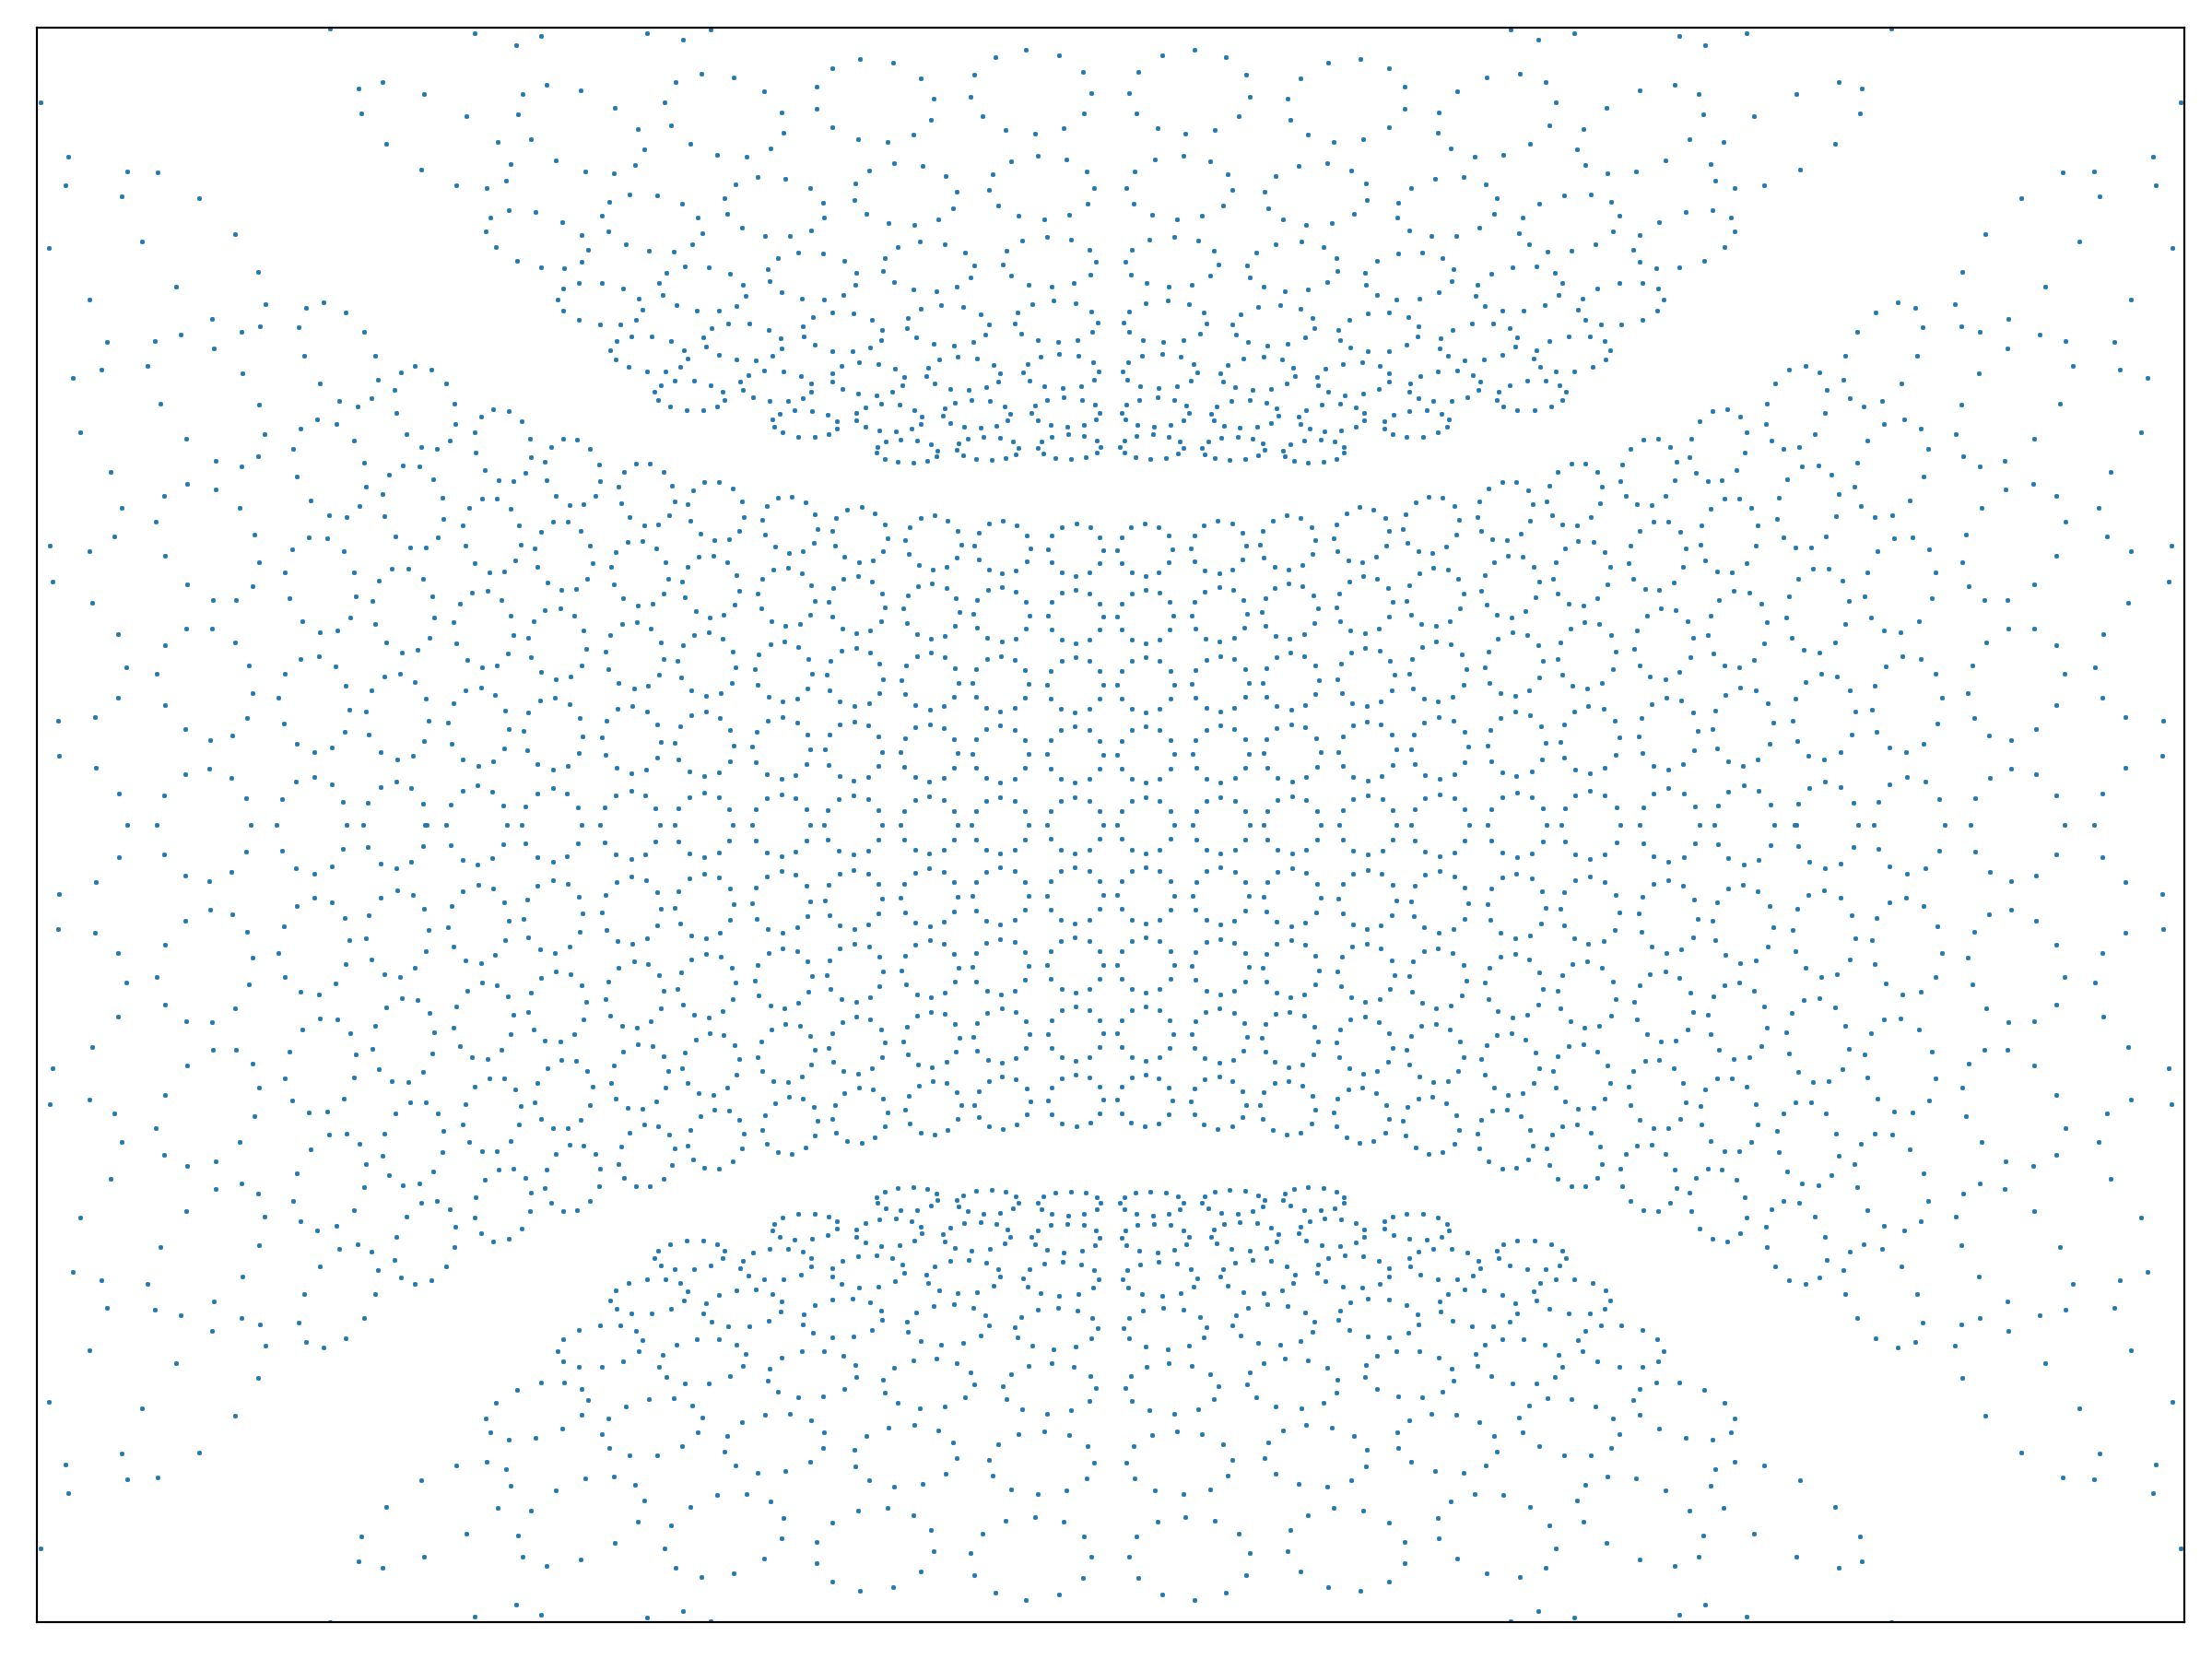

<IPython.core.display.Javascript object>


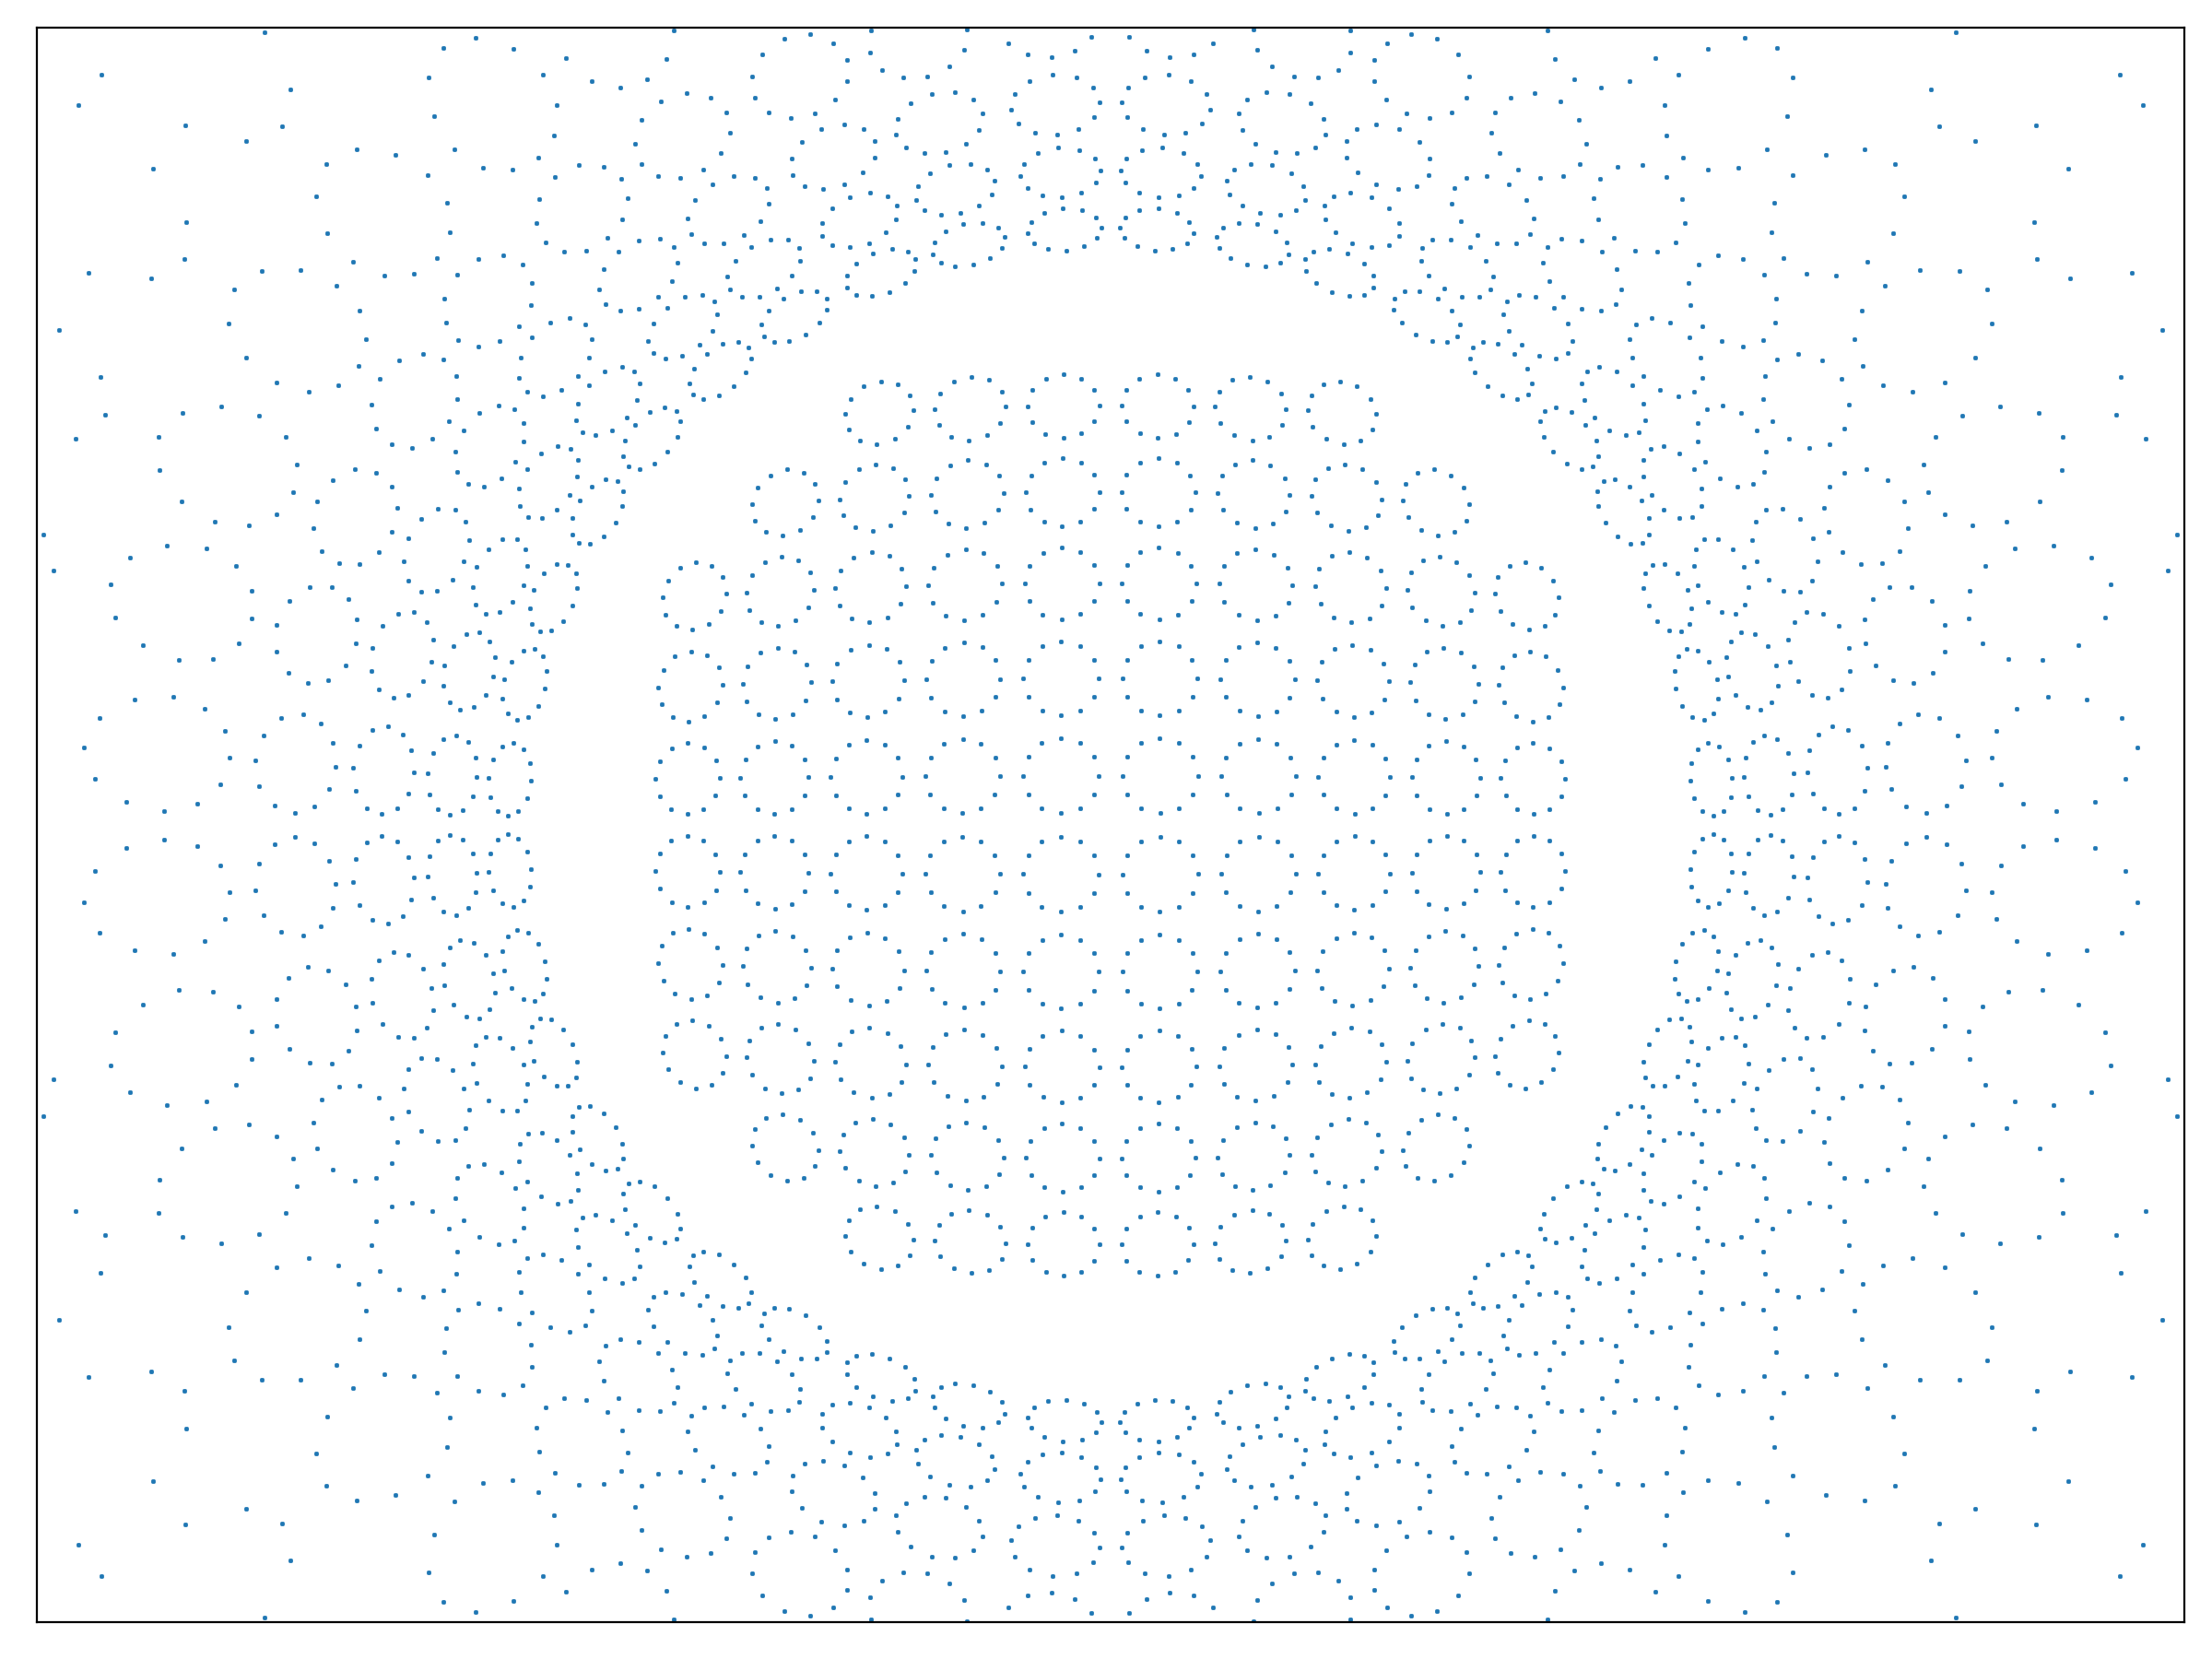

<IPython.core.display.Javascript object>


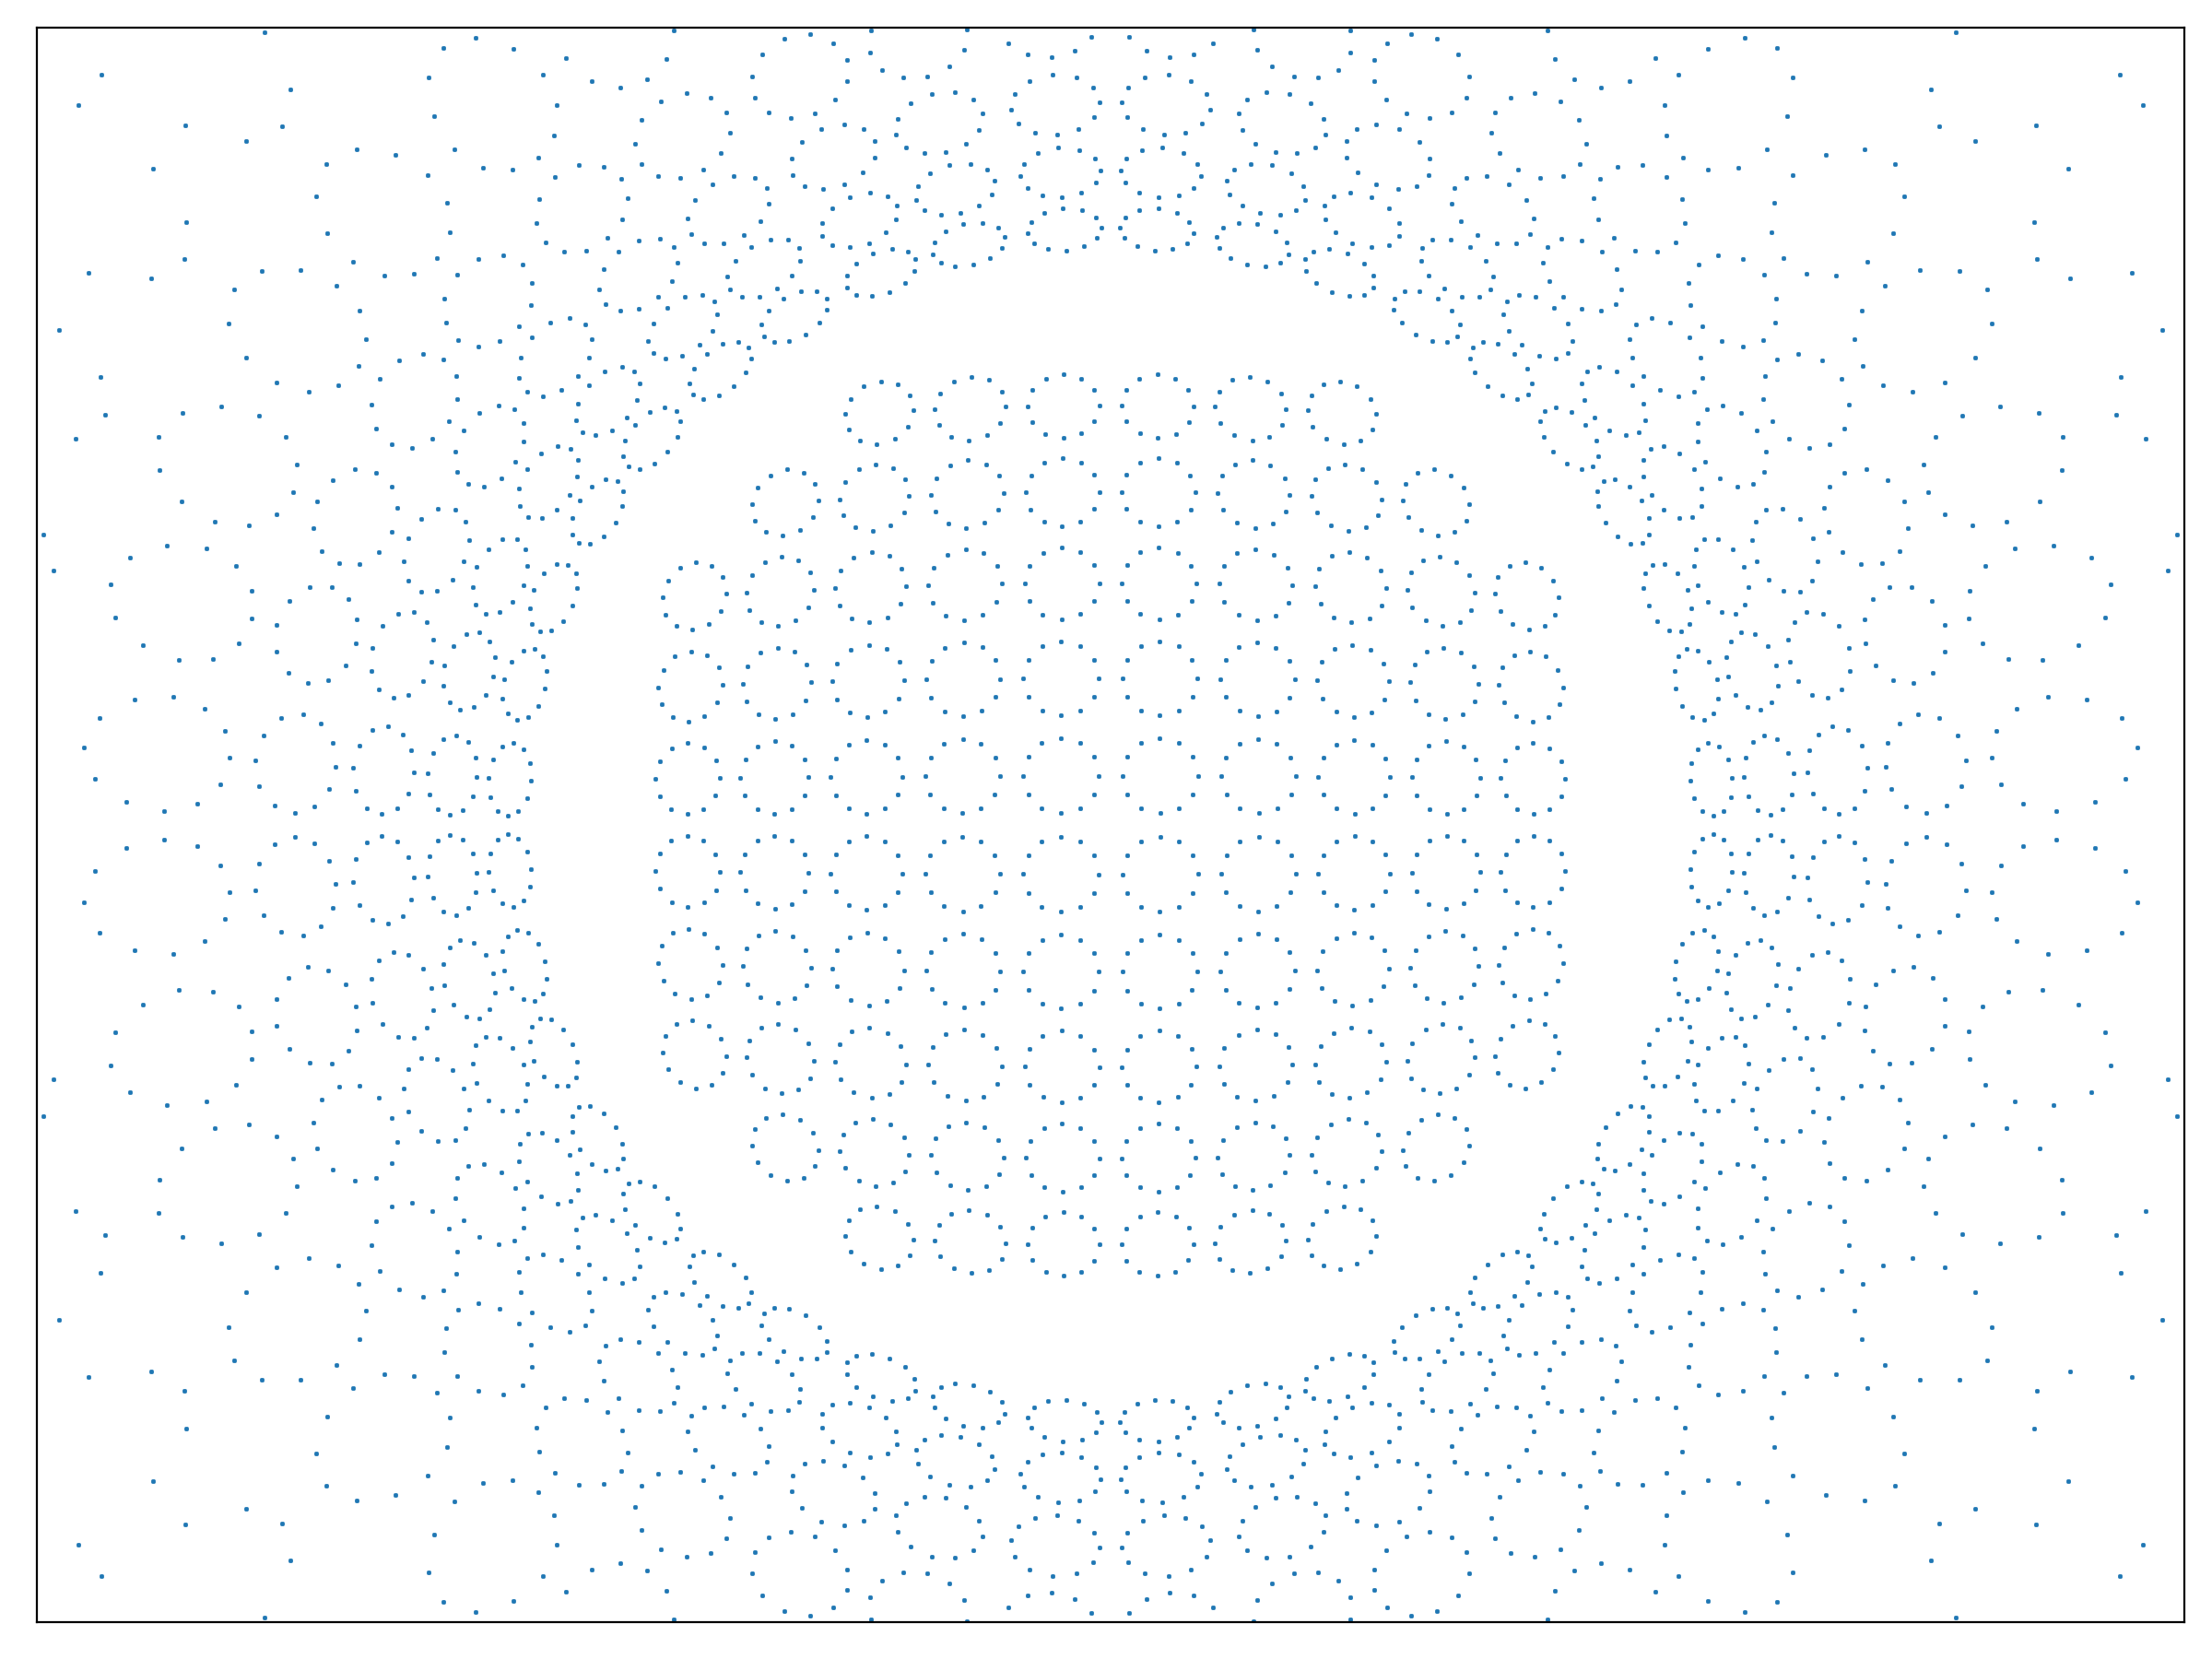

In [24]:
for i in image_feature_locations.values():
    fig, ax = plt.subplots(figsize=(12,9))
    coords = np.rint(np.stack(list(i.values())))
#    pixels = [matplotlib.patches.Rectangle((c[0],-c[1]), 1, 1) for c in coords]
#    collection = matplotlib.collections.PatchCollection(pixels, facecolor='black')
#    ax.add_collection(collection)
    ax.scatter(coords[:,0], -coords[:,1], marker='s', s=0.2)
    ax.set_xlim((0, 4000))
    ax.set_ylim((-3000, 0))
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    fig.tight_layout()
#    for t, f in i.items():
#        ax.text(f[0], -f[1], t, size=4, zorder=4, color='k')

In [26]:
pixel_error = 0.5
shifted_feature_locations = {}
for k, i in image_feature_locations.items():
    shifted_feature_locations[k] = {}
    for j, f in i.items():
        shifted_feature_locations[k][j] = np.random.normal(f, pixel_error)
guess_error = 1
guess_feature_locations = {}
for i, f in led_positions_12.items():
    guess_feature_locations[i] = np.random.normal(f, guess_error)

In [27]:
feature_counts = Counter([f for i in shifted_feature_locations.values() for f in i.keys()])
Counter(feature_counts.values())

Counter({4: 3544, 3: 2480, 5: 408})

In [28]:
fitter = fit.PhotogrammetryFitter(shifted_feature_locations, guess_feature_locations,
                                  focal_length, principle_point, radial_distortion)

In [29]:
reco_cam_rotations, reco_cam_translations, reprojected_points = fitter.estimate_camera_poses()

image 0 reprojection errors:    average: 4.240745139312469    max: 319.77483763050293
image 1 reprojection errors:    average: 4.376828620978009    max: 382.0053696670437
image 2 reprojection errors:    average: 4.419376812770263    max: 497.51166956409
image 3 reprojection errors:    average: 4.306032970078203    max: 459.6075224813506
image 4 reprojection errors:    average: 4.5976113846993    max: 48.626074719319135
image 5 reprojection errors:    average: 4.585673601313451    max: 41.50553068599476


In [30]:
reco_cam_rotations, reco_cam_translations, reco_locations = fitter.bundle_adjustment(reco_cam_rotations, reco_cam_translations)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.5586e+05                                    3.50e+07    
       1              2         2.0646e+04      7.35e+05       1.20e+02       4.39e+06    
       2              3         4.9929e+03      1.57e+04       2.61e+01       9.43e+04    
       3              4         4.5427e+03      4.50e+02       6.08e+00       1.28e+04    
       4              5         4.3042e+03      2.38e+02       2.35e+00       2.48e+03    
       5              6         4.2251e+03      7.91e+01       1.21e+00       1.37e+03    
       6              7         4.1726e+03      5.25e+01       7.70e-01       8.91e+02    
       7              8         4.1315e+03      4.12e+01       6.90e-01       9.96e+02    
       8              9         4.0999e+03      3.16e+01       4.33e-01       7.99e+02    
       9             10         4.0847e+03      1.52e+01       1.89e-01       5.21e+02    

In [31]:
errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(led_positions_12, reco_locations)
print("mean reconstruction error:", linalg.norm(errors, axis=1).mean())
print("max reconstruction error:", linalg.norm(errors, axis=1).max())

mean reconstruction error: 0.21249867868242955
max reconstruction error: 1.3053406464637123


In [32]:
reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(reco_cam_rotations, reco_cam_translations)
cam_orientations_transformed = np.matmul(R, reco_cam_orientations)
cam_positions_translated = reco_cam_positions - translation
cam_positions_transformed = scale*R.dot(cam_positions_translated.transpose()).transpose()

In [33]:
print(cam_positions_transformed)
print(reco_cam_translations)
print(camera_translations)

[[-1.45905129e-02 -1.52611123e-02 -4.00003138e+02]
 [-1.79206419e-02 -8.78260269e-03  4.00001766e+02]
 [-4.00001248e+02  8.64719116e-03 -7.89710502e-03]
 [ 3.99996493e+02  1.56807584e-02 -8.19500655e-03]
 [-1.47146281e-02 -3.00007789e+02 -2.22475538e-02]
 [ 6.34014240e-04  2.99998646e+02  2.36239085e-02]]
[[-4.12372954e-03  1.39564044e-02  4.00001263e+02]
 [ 1.54855585e-03  1.06217829e-02  4.00008028e+02]
 [ 1.54345671e-04  5.13523171e-03  3.99994134e+02]
 [-8.68487644e-04  3.68799477e-03  4.00007992e+02]
 [-2.18424520e-03 -9.37311899e-03  3.00017650e+02]
 [ 1.57664055e-02 -6.65290198e-03  2.99992075e+02]]
[[  0.   0. 400.]
 [  0.   0. 400.]
 [  0.   0. 400.]
 [  0.   0. 400.]
 [  0.   0. 300.]
 [  0.   0. 300.]]


<IPython.core.display.Javascript object>


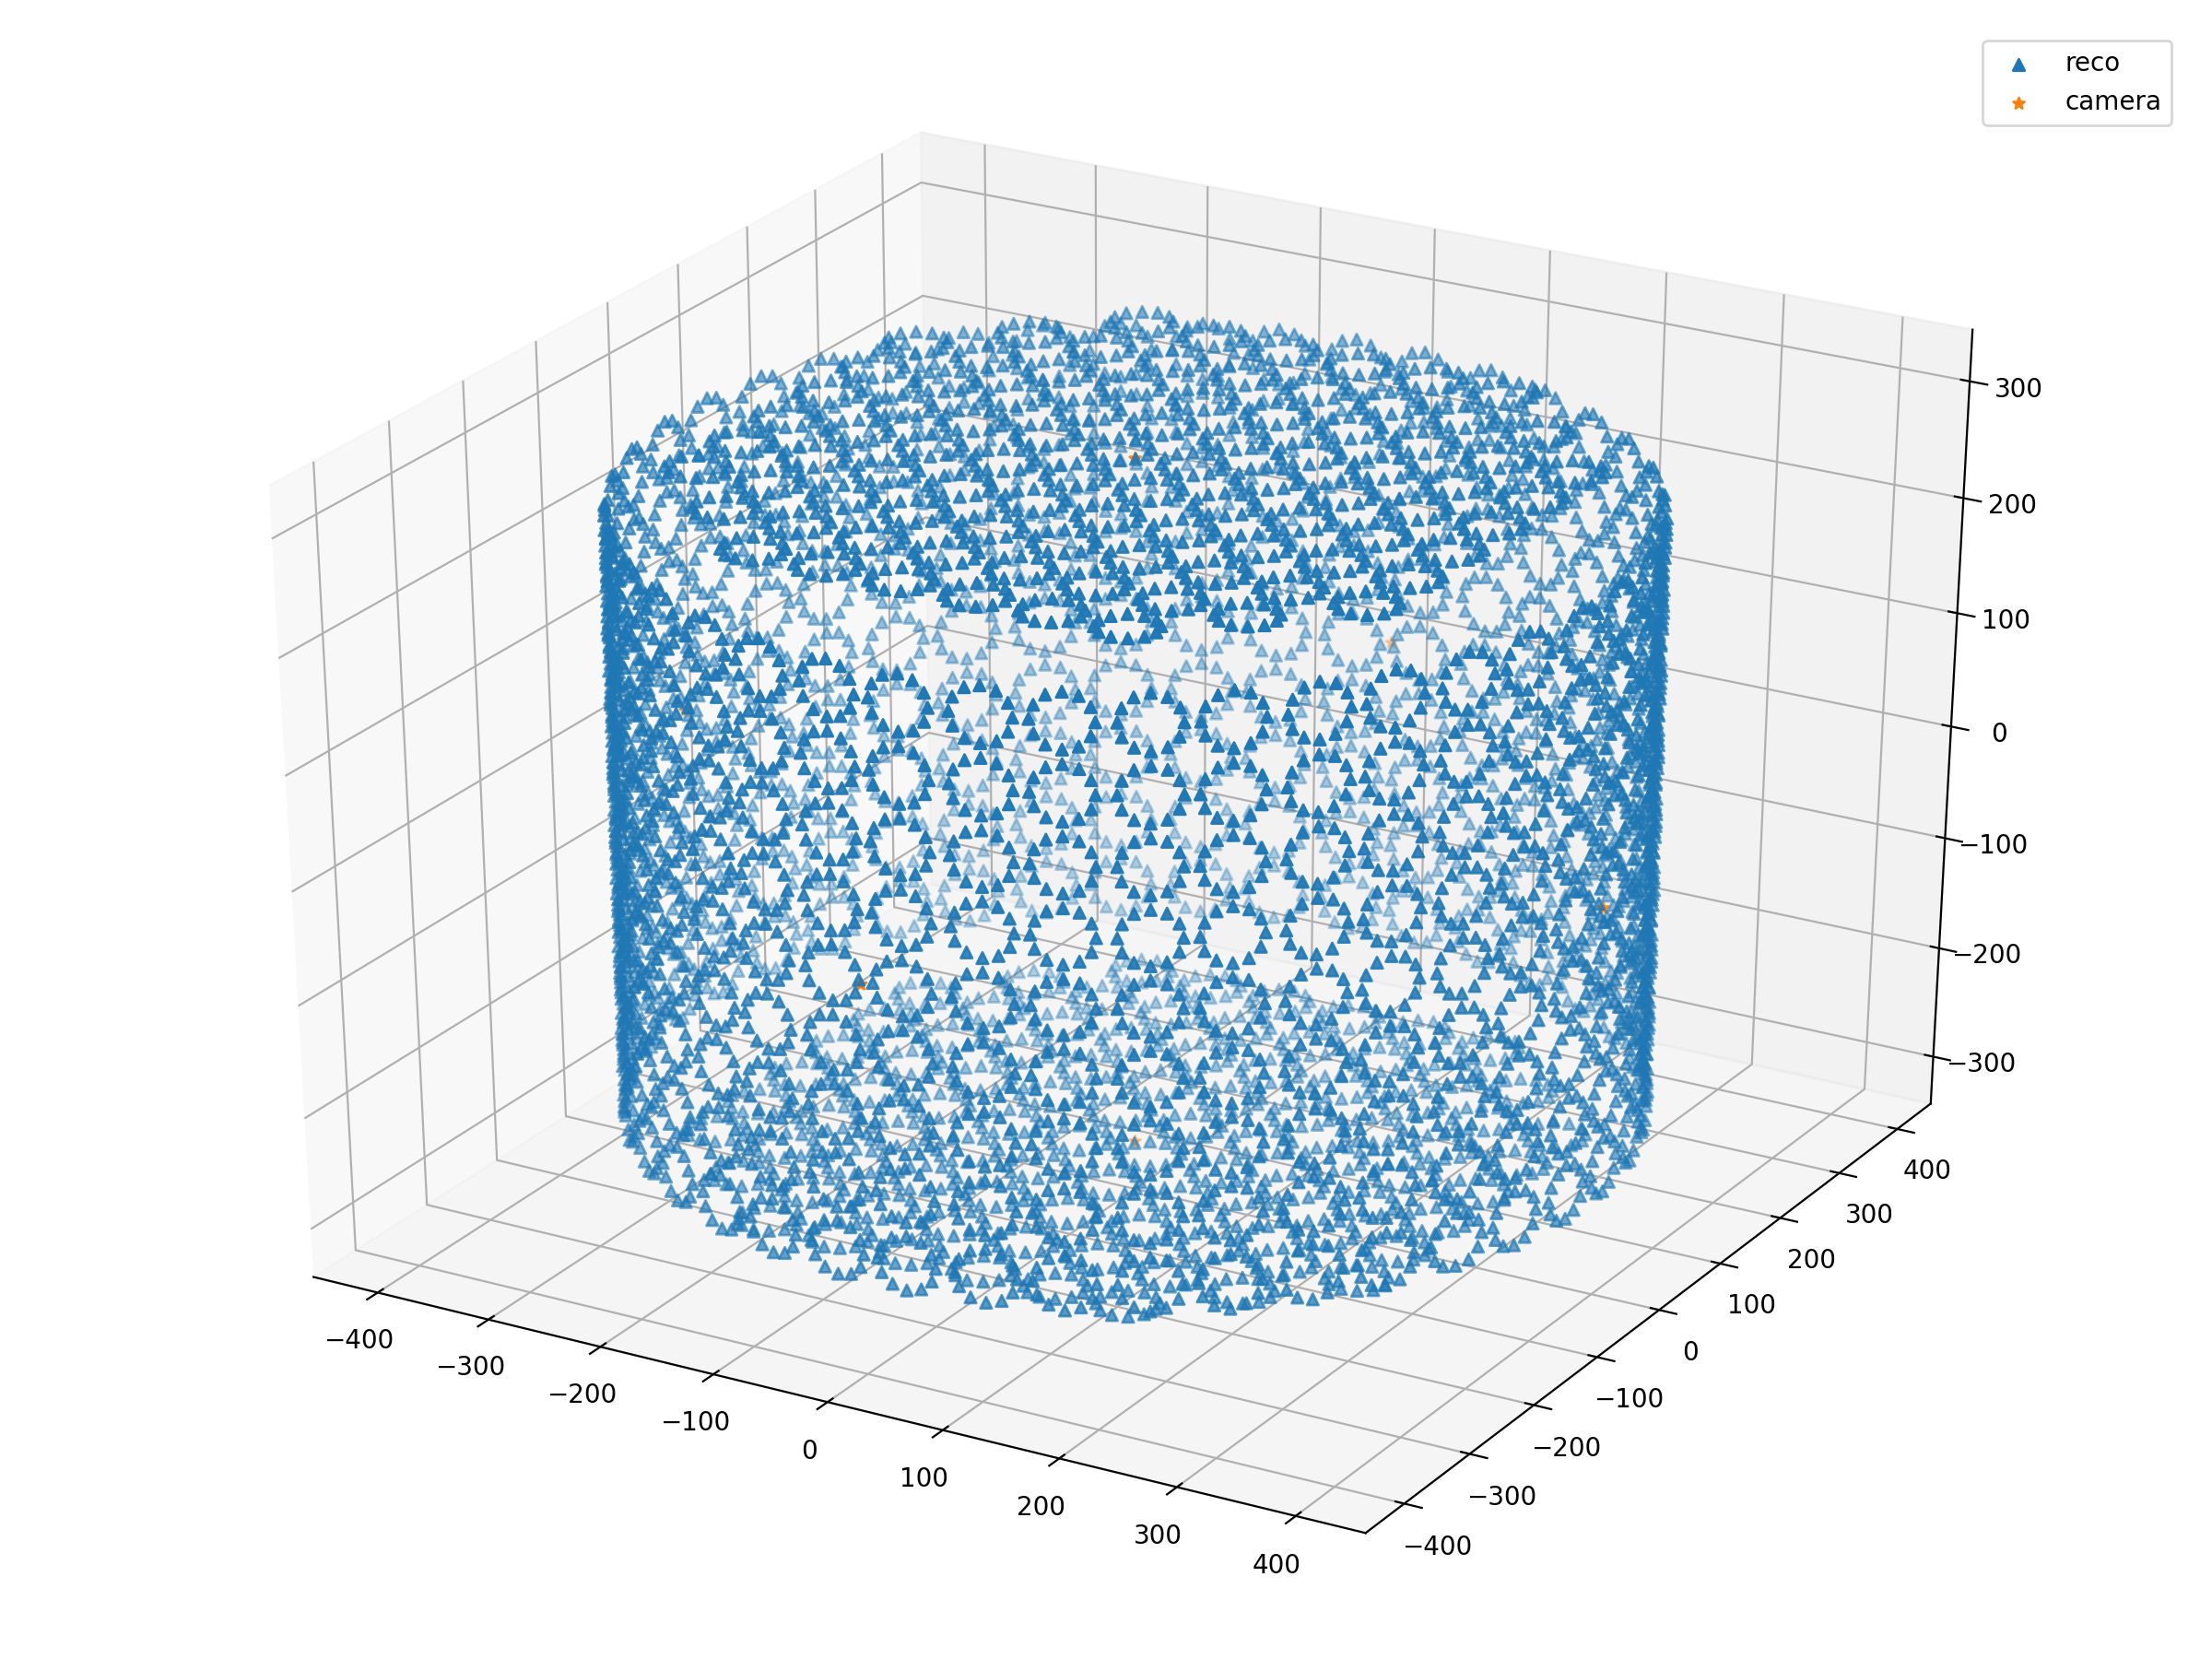

In [34]:
#true_array = np.stack(list(common_feature_locations.values()))
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reco_transformed[:,0], reco_transformed[:,2], reco_transformed[:,1], marker='^', label="reco")
#ax.scatter(true_array[:,0], true_array[:,1], true_array[:,2], marker='o', label="true")
#for i, f in enumerate(pmt_locations.keys()):
#    ax.text(true_array[i,0], true_array[i,1], true_array[i,2], f, size=4, zorder=1, color='k') 
ax.scatter(cam_positions_transformed[:,0], cam_positions_transformed[:,2], cam_positions_transformed[:,1],
           marker='*', label="camera")
plt.legend(loc=0)
fig.tight_layout()

<IPython.core.display.Javascript object>


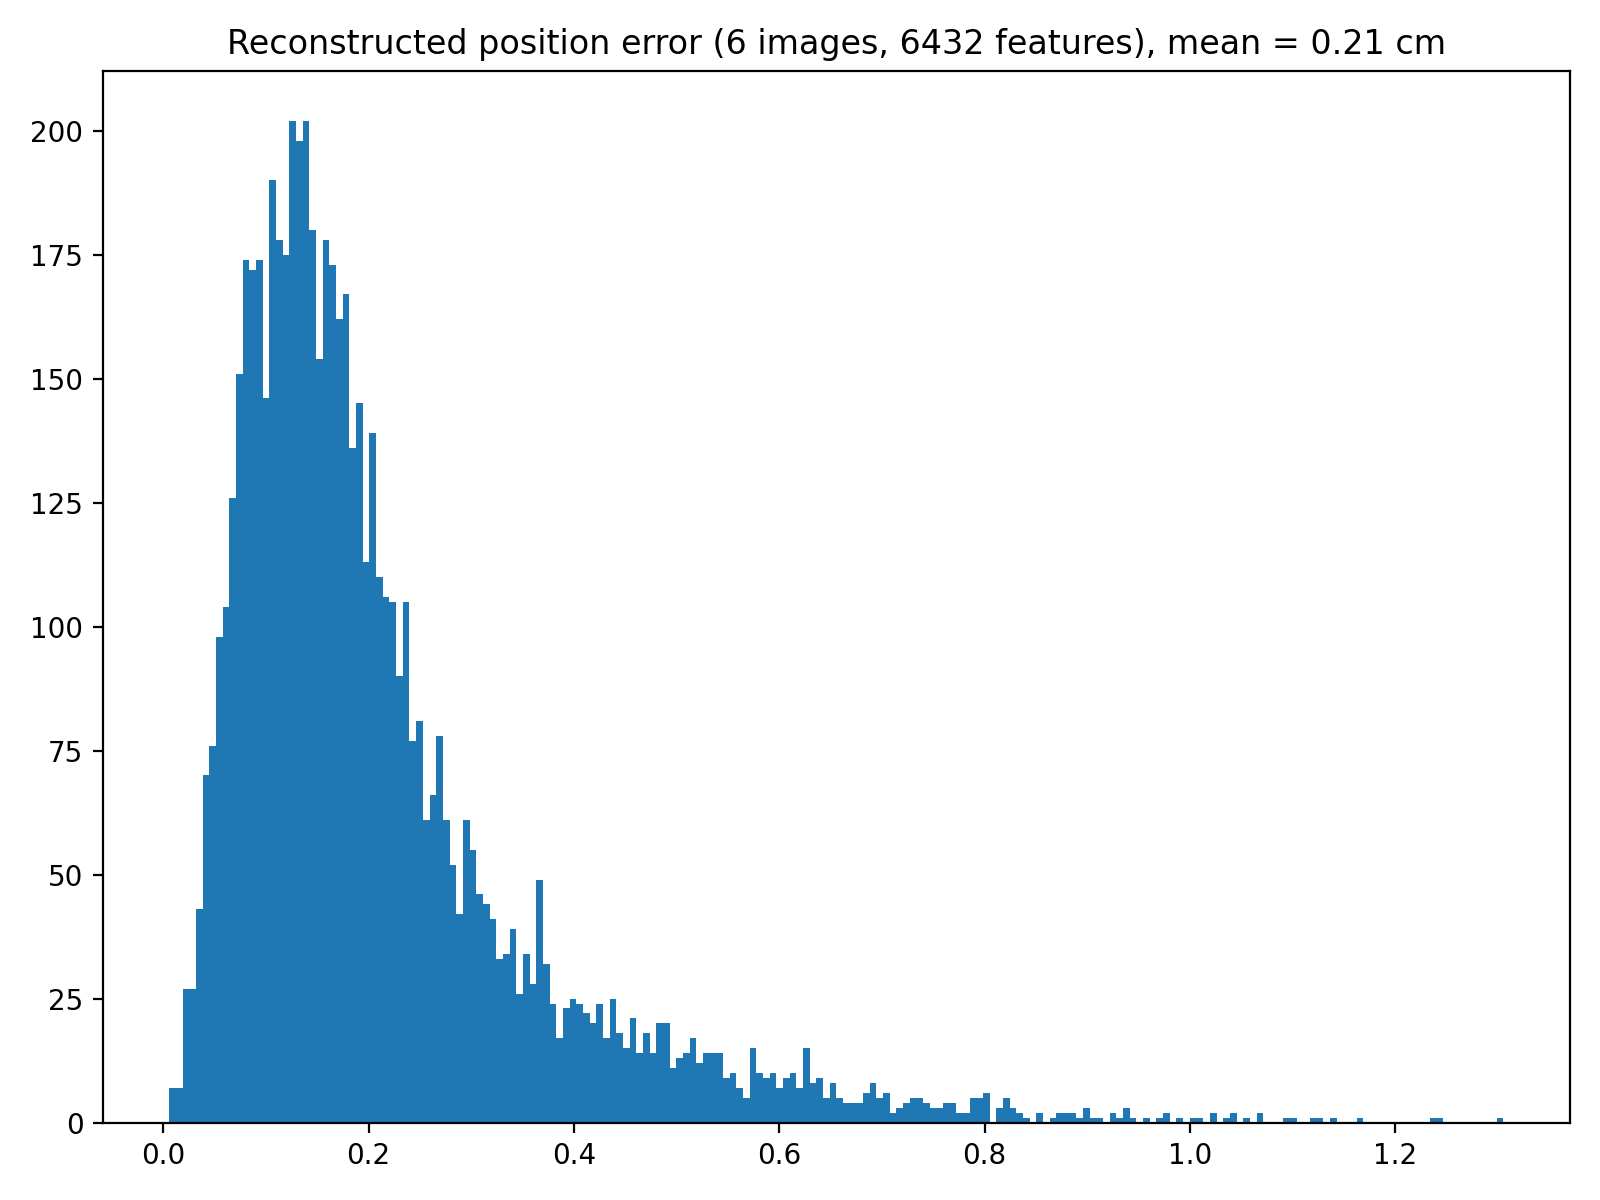

In [35]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(linalg.norm(errors, axis=1), bins=200)
ax.set_title("Reconstructed position error ({} images, {} features), mean = {:.2f} cm".format(
    nimages, nfeatures, linalg.norm(errors, axis=1).mean()))
fig.tight_layout()